In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from utilities import (image_preprocess, of_cg)
from image_gen import generate_test_image

## TMA4205 - Estimation of Optical Flow
##### Julie Rose Godal og Tor Løvold Haugen
----

Innledning

Oppgave 1/Teori

## Discrete equations

The discrete system is

$$
\partial_x I_{ij}^2\, u_{ij} 
+ \partial_x I_{ij}\, \partial_y I_{ij}\, v_{ij}
- \lambda (A_h^0 u)_{ij}
= - (\partial_t I)_{ij} (\partial_x I)_{ij},
$$

$$
\partial_y I_{ij}^2\, v_{ij}
+ \partial_y I_{ij}\, \partial_x I_{ij}\, u_{ij}
- \lambda (A_h^0 v)_{ij}
= - (\partial_t I)_{ij} (\partial_y I)_{ij}.
$$

Define

$$
I_x := \partial_x I, \qquad
I_y := \partial_y I, \qquad
I_t := \partial_t I.
$$

Then

$$
I_x^2 u + I_x I_y v - \lambda A_h^0 u = - I_t I_x,
$$

$$
I_y^2 v + I_x I_y u - \lambda A_h^0 v = - I_t I_y.
$$

Define diagonal matrices

$$
D_{xx} = \mathrm{diag}(I_x^2), \qquad
D_{yy} = \mathrm{diag}(I_y^2), \qquad
D_{xy} = \mathrm{diag}(I_x I_y),
$$

so the system becomes

$$
\begin{bmatrix}
D_{xx} - \lambda A_h^0 & D_{xy} \\
D_{xy} & D_{yy} - \lambda A_h^0
\end{bmatrix}
\begin{bmatrix}
U \\[2pt] V
\end{bmatrix}
=
\begin{bmatrix}
D_{xt} \\[2pt] D_{yt}
\end{bmatrix}.
$$

Thus \(A\) is symmetric.

---

## Positive definiteness

Split \(A\) into a Laplacian part \(L\) and diagonal part \(D\):

$$
A =
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}
-
\begin{bmatrix}
\lambda A_h^0 & 0 \\
0 & \lambda A_h^0
\end{bmatrix}.
$$

Since the Laplacian with Dirichlet boundary conditions is SPD.

For the diagonal part \(D\), let \(x_1, x_2 \in \mathbb{R}\). Then

$$
x^T D x
=
\begin{bmatrix} x_1 & x_2 \end{bmatrix}
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
=
x_1^2 D_{xx} + 2x_1 x_2 D_{xy} + x_2^2 D_{yy}.
$$

Since the matrices are diagonal,

$$
x^T D x
= \sum_i (x_1 I_{x,i} + x_2 I_{y,i})^2 > 0,
$$

so \(D\) is SPD.

---

## Diagonal dominance

Let

$$
A =
\begin{bmatrix}
D_{xx} - \lambda A_h^0 & D_{xy} \\
D_{xy} & D_{yy} - \lambda A_h^0
\end{bmatrix}.
$$

Because \(D_{xx},D_{yy}\) are diagonal and the Laplacian \(A_h^0\) has diagonal entries \(d_i>0\) and \(-1\) on neighbors:

### \(u\)-block row

Diagonal entry:

$$
a_{ii} = I_x[i]^2 + \lambda d_i,
$$

Off-diagonal:

- Neighbor entries: \(a_{ij} = -\lambda\) for \(j\in \mathcal{N}(i)\)
- Cross block: \(a_{i,N+i} = I_x[i] I_y[i]\)

Diagonal dominance requires

$$
|a_{ii}| \ge \sum_{j\neq i} |a_{ij}|
\quad\Rightarrow\quad
I_x[i]^2 + \lambda d_i \ge \lambda d_i + |I_x[i] I_y[i]|
$$

i.e.

$$
I_x[i]^2 \ge |I_x[i] I_y[i]|.
$$

### \(v\)-block row

Similar reasoning gives

$$
I_y[i]^2 \ge |I_x[i] I_y[i]|.
$$

Thus the conditions are

$$
|I_x[i]| \ge |I_y[i]|, \qquad
|I_y[i]| \ge |I_x[i]|.
$$

Both hold only when

$$
|I_x[i]| = |I_y[i]|.
$$

Hence **global diagonal dominance of \(A\)** cannot be guaranteed.

---


We estimate a dense flow field $(u,v)$ between two consecutive grayscale frames $I_0$ and $I_1$ using the Horn–Schunck model. The brightness constancy idea, combined with quadratic smoothness, leads to the energy
$$
E(u,v)=\int \big( (I_x u + I_y v + I_t)^2 + \lambda(\|\nabla u\|^2+\|\nabla v\|^2) \big)\,dx\,dy,
$$
where $\lambda>0$ balances data fidelity and regularity. The Euler–Lagrange equations give a coupled linear system on the image domain
$$
(I_x^2)u + (I_x I_y)v - \lambda \Delta u = -I_x I_t,\qquad
(I_x I_y)u + (I_y^2)v - \lambda \Delta v = -I_y I_t,
$$
with Dirichlet conditions $u=v=0$ on the boundary.

Discretization uses an $m\times n$ grid with unit spacing: $I_t=I_1-I_0$, $I_x$ and $I_y$ from forward differences averaged across the two frames, and a five-point Laplacian applied only on the strict interior. Boundary pixels are excluded from all linear algebra and kept at zero, which enforces the conditions.

The discrete operator on $(u,v)$ can be written compactly as
$$
A(u,v)=
\begin{bmatrix}
I_x^2 & I_x I_y\\
I_x I_y & I_y^2
\end{bmatrix}
\begin{bmatrix}u\\ v\end{bmatrix}
-\lambda
\begin{bmatrix}\Delta u\\ \Delta v\end{bmatrix},
\qquad
b=\begin{bmatrix}-I_x I_t\\ -I_y I_t\end{bmatrix}.
$$
On the interior this operator is symmetric and typically positive definite, so the linear system $A(u,v)=b$ is solved efficiently with Conjugate Gradient. All inner products and updates are restricted to interior indices, while the border remains clamped to zero. Convergence is declared when the relative residual
$$
\frac{\|r_k\|_2}{\|r_0\|_2} < \texttt{tol}, \qquad
\|r_k\|_2^2 = \langle r_u,r_u\rangle + \langle r_v,r_v\rangle,
$$
drops below the prescribed tolerance.


oppgave 3

oppgave 4

Numerical tests

In [ ]:
frame0_path = "test_images/frame10.png"
frame1_path = "test_images/frame11.png"
Im_0 = mpimg.imread(frame0_path)
Im_1 = mpimg.imread(frame1_path)

n = 128                                          # image size
Im_0, Im_1 = generate_test_image(n, testcase=1)  # or 2


lam = 0.2
tol = 1e-8
maxit = 20000
sigma = 1.0
step = 12
scale = 80

u0, v0, Ix, Iy, rhsu, rhsv, I0, I1 = image_preprocess(Im_0, Im_1, sigma)
u, v, it, rel = of_cg(u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit)
print(f"Done: iterations={it}, final rel_res^2={rel:.3e}")

Image dimensions: (128, 128), value: 0.014242403619608995
Done: iterations=1485, final rel_res^2=9.899e-09


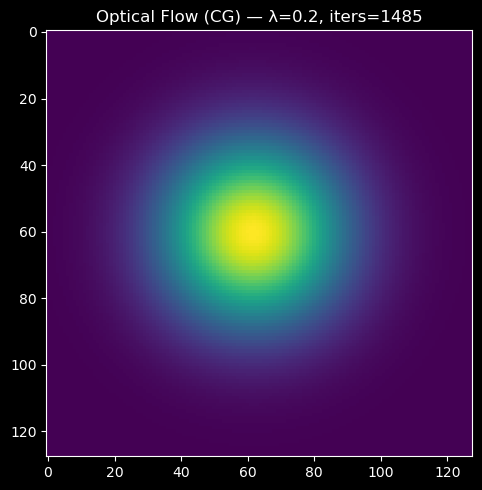

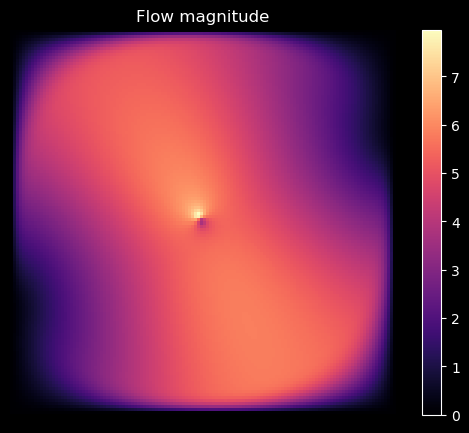

In [18]:
Y, X = np.mgrid[0:u.shape[0]:step, 0:u.shape[1]:step]

plt.figure(figsize=(7, 5))
plt.imshow(I0, origin="lower")
plt.gca().invert_yaxis()
plt.title(f"Optical Flow (CG) — λ={lam}, iters={it}")
plt.tight_layout()
plt.show()


mag = np.hypot(u, v)
plt.figure(figsize=(7,5))
plt.imshow(mag, cmap="magma")
plt.colorbar()
plt.title("Flow magnitude")
plt.axis("off")
plt.show()
